In [1]:
library(data.table)
library(ComplexHeatmap)


Lade n"otiges Paket: grid

ComplexHeatmap version 2.15.4
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [2]:
library(extrafont)
font_import(paths = "/Library/Fonts", prompt = FALSE)
loadfonts()
fonts()


Registering fonts with R

Scanning ttf files in /Library/Fonts ...

Extracting .afm files from .ttf files...

/System/Library/Fonts/Supplemental/Arial Unicode.ttf
 : ArialUnicodeMS already registered in fonts database. Skipping.

/Library/Fonts/FontsFree-Net-MYRIADPRO-REGULAR.ttf
 : MyriadPro-Regular already registered in fonts database. Skipping.

Found FontName for 0 fonts.

Scanning afm files in /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/library/extrafontdb/metrics

Arial Unicode MS already registered with pdfFont().

Myriad Pro already registered with pdfFont().

Arial Unicode MS already registered with postscriptFont().

Myriad Pro already registered with postscriptFont().



[1] "Arial Unicode MS" "Myriad Pro"

## Visualisation of concordance between genetic and hashing deconvolution methods through confusion matrix


In [3]:
# Load hashing deconvolution results
hash_gene_result <-
    fread(
        "../data/pipeline_output/gx12/assignment_all_genetic_and_hash.csv",
        na.strings = ""
    )

# Remove the trial ID
colnames(hash_gene_result) <-
    c(
        "Barcode",
        "Freemuxlet",
        "scSplit",
        "Souporcell",
        "Vireo",
        "DemuxEM",
        "HashSolo",
        "HTODemux",
        "Multiseq",
        "HashedDrops",
        "GMM_Demux",
        "BFF"
    )

# Subset by only those cells detected by RNA
white_list_gx12 <-
    fread("../data/dataset/barcodes_gx12.tsv", header = FALSE)$V1
hash_gene_result <- hash_gene_result[Barcode %in% white_list_gx12, ]

# Remove TotalSeqA suffix
hash_gene_result$HTODemux <-
    gsub("-TotalSeqA", "", hash_gene_result$HTODemux)
hash_gene_result$Multiseq <-
    gsub("-TotalSeqA", "", hash_gene_result$Multiseq)
hash_gene_result$DemuxEM <-
    gsub("_TotalSeqA", "", hash_gene_result$DemuxEM)
hash_gene_result$HashSolo <-
    gsub("_TotalSeqA", "", hash_gene_result$HashSolo)
hash_gene_result$GMM_Demux <-
    gsub("_TotalSeqA", "", hash_gene_result$GMM_Demux)

# Rename HashedDrops donor
hash_gene_result$HashedDrops <-
    ifelse(
        hash_gene_result$HashedDrops != "negative",
        paste0("Hash45", hash_gene_result$HashedDrops),
        hash_gene_result$HashedDrops
    )

head(hash_gene_result)


Barcode,Freemuxlet,scSplit,Souporcell,Vireo,DemuxEM,HashSolo,HTODemux,Multiseq,HashedDrops,GMM_Demux,BFF
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGTGTGAC-1,5,6,4,donor1,Hash454,Hash453,Hash453,Hash454,negative,negative,doublet
AAACCCAGTGAGAGGG-1,4,1,5,donor2,Hash453,Hash453,negative,doublet,NA,negative,doublet
AAACGAAAGAATCTAG-1,2,5,2,donor5,negative,Hash453,negative,negative,negative,negative,doublet
AAACGAACACATATGC-1,2,0,2,donor5,Hash456,Hash453,negative,negative,negative,negative,doublet
AAACGAACACGACTAT-1,2,0,2,donor5,Hash452,Hash453,Hash453,Hash452,negative,negative,doublet
AAACGAACATCAGCAT-1,1,3,0,donor0,negative,Hash453,Hash453,negative,negative,negative,doublet


In [4]:
# Change plot size to 10 x 8
options(repr.plot.width = 10, repr.plot.height = 8)
cpalette <- circlize::colorRamp2(c(0, 150, 300, 450), hcl.colors(5, "Blues 3", rev = T)[1:4])


Warning message:
"The input is a data frame-like object, convert it to a matrix."


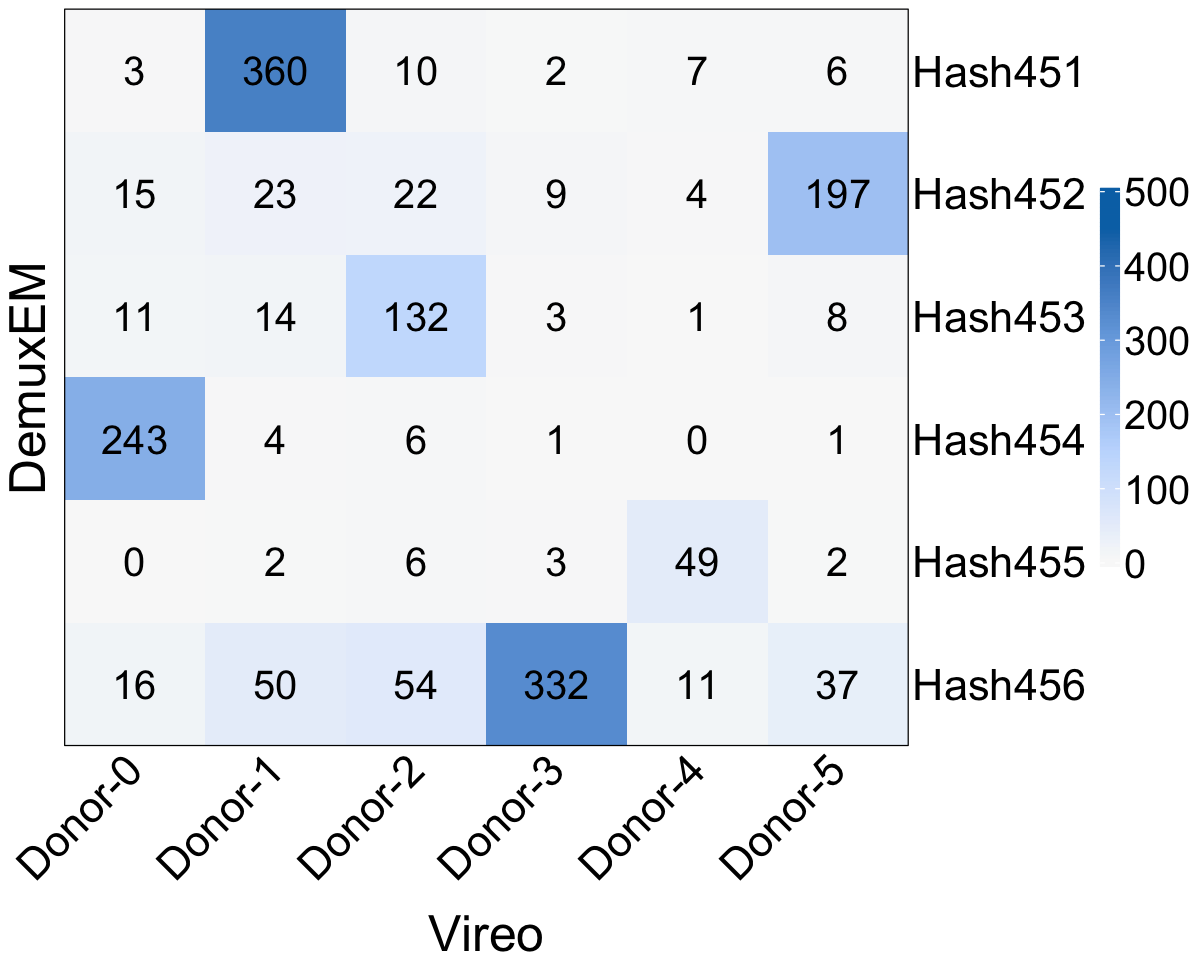

In [5]:
# Create an empyt matrix
confusion_matrix_v_demuxem <-
  as.data.frame(matrix(ncol = 6, nrow = 6))
donor_list <- paste0("Hash45", 1:6)
donor_list_vireo <- paste0("donor", 0:5)
colnames(confusion_matrix_v_demuxem) <- donor_list_vireo
rownames(confusion_matrix_v_demuxem) <- donor_list

for (j in c(0:5)) {
  for (i in c(1:6)) {
    row <- nrow(hash_gene_result[hash_gene_result$Vireo == donor_list_vireo[j + 1] &
      hash_gene_result$DemuxEM == donor_list[i], ])
    confusion_matrix_v_demuxem[i, j + 1] <- row
  }
}

colnames(confusion_matrix_v_demuxem) <- paste0("Donor-", 0:5)

# pdf(
#   "s4/heatmap-v-demuxem-gx12.pdf",
#   family = "Myriad Pro",
#   height = 8,
#   width = 10
# )

Heatmap(
  confusion_matrix_v_demuxem,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "DemuxEM",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_demuxem[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)

# dev.off()


Warning message:
"The input is a data frame-like object, convert it to a matrix."


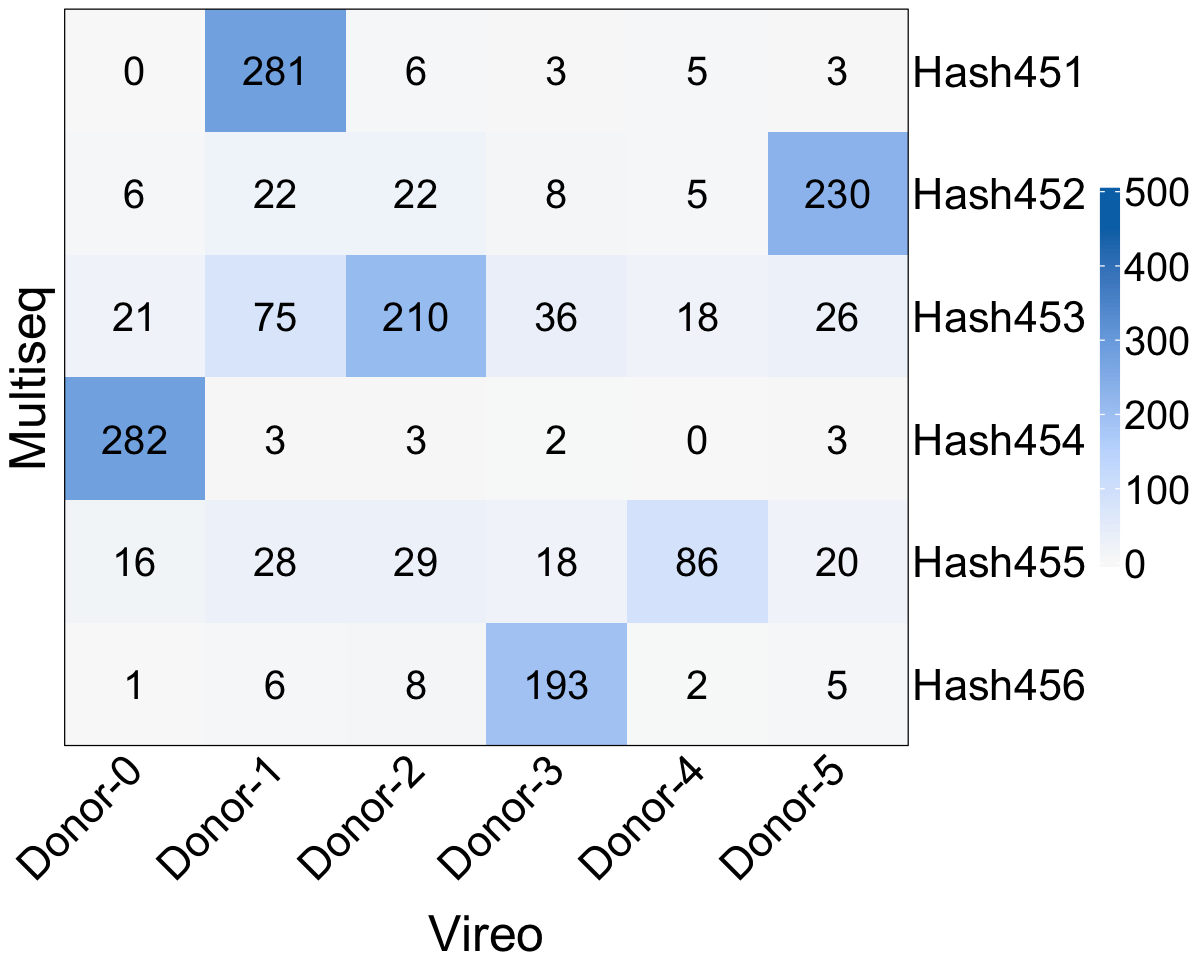

In [6]:
# Create an empyt matrix
confusion_matrix_v_multiseq <-
  as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_multiseq) <- donor_list_vireo
rownames(confusion_matrix_v_multiseq) <- donor_list

for (j in c(0:5)) {
  for (i in c(1:6)) {
    row <-
      nrow(hash_gene_result[hash_gene_result$Vireo == donor_list_vireo[j + 1] &
        hash_gene_result$Multiseq == donor_list[i], ])
    confusion_matrix_v_multiseq[i, j + 1] <- row
  }
}

colnames(confusion_matrix_v_multiseq) <- paste0("Donor-", 0:5)

# pdf(
#   "s4/heatmap-v-multiseq-gx12.pdf",
#   family = "Myriad Pro",
#   height = 8,
#   width = 10
# )

Heatmap(
  confusion_matrix_v_multiseq,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "Multiseq",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_multiseq[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)
# dev.off()


Warning message:
"The input is a data frame-like object, convert it to a matrix."


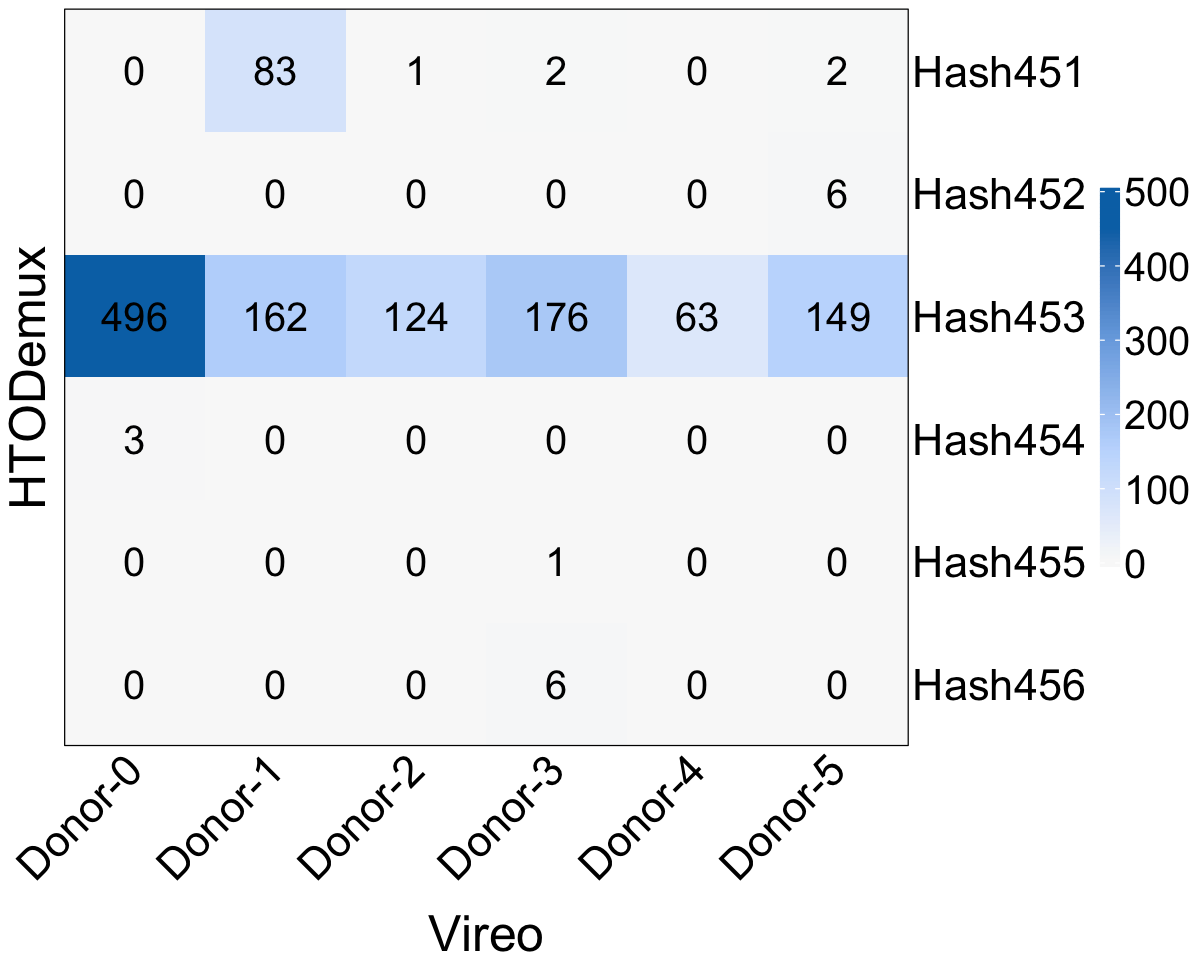

In [7]:
confusion_matrix_v_htodemux <-
  as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_htodemux) <- donor_list_vireo
rownames(confusion_matrix_v_htodemux) <- donor_list

for (j in c(0:5)) {
  for (i in c(1:6)) {
    row <-
      nrow(hash_gene_result[hash_gene_result$Vireo == donor_list_vireo[j + 1] &
        hash_gene_result$HTODemux == donor_list[i], ])
    confusion_matrix_v_htodemux[i, j + 1] <- row
  }
}

colnames(confusion_matrix_v_htodemux) <- paste0("Donor-", 0:5)

# pdf(
#   "s4/heatmap-v-htodemux-gx12.pdf",
#   family = "Myriad Pro",
#   height = 8,
#   width = 10
# )

Heatmap(
  confusion_matrix_v_htodemux,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "HTODemux",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_htodemux[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)

# dev.off()


Warning message:
"The input is a data frame-like object, convert it to a matrix."


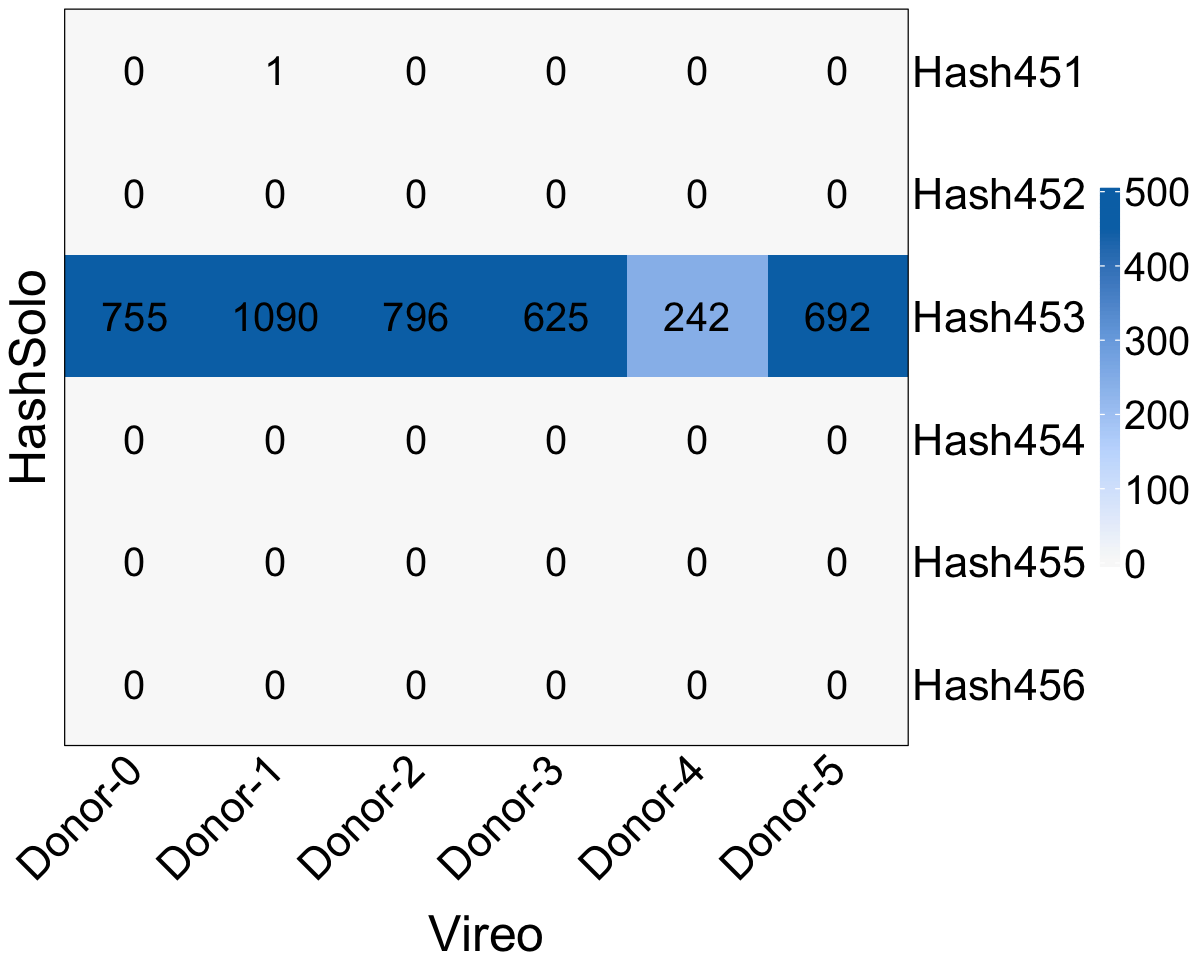

In [8]:
confusion_matrix_v_hashsolo <-
  as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_hashsolo) <- donor_list_vireo
rownames(confusion_matrix_v_hashsolo) <- donor_list

for (j in c(0:5)) {
  for (i in c(1:6)) {
    row <-
      nrow(hash_gene_result[hash_gene_result$Vireo == donor_list_vireo[j + 1] &
        hash_gene_result$HashSolo == donor_list[i], ])
    confusion_matrix_v_hashsolo[i, j + 1] <- row
  }
}

colnames(confusion_matrix_v_hashsolo) <- paste0("Donor-", 0:5)

# pdf(
#   "s4/heatmap-v-hashsolo-gx12.pdf",
#   family = "Myriad Pro",
#   height = 8,
#   width = 10
# )

Heatmap(
  confusion_matrix_v_hashsolo,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "HashSolo",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_hashsolo[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)
# dev.off()


Warning message:
"The input is a data frame-like object, convert it to a matrix."


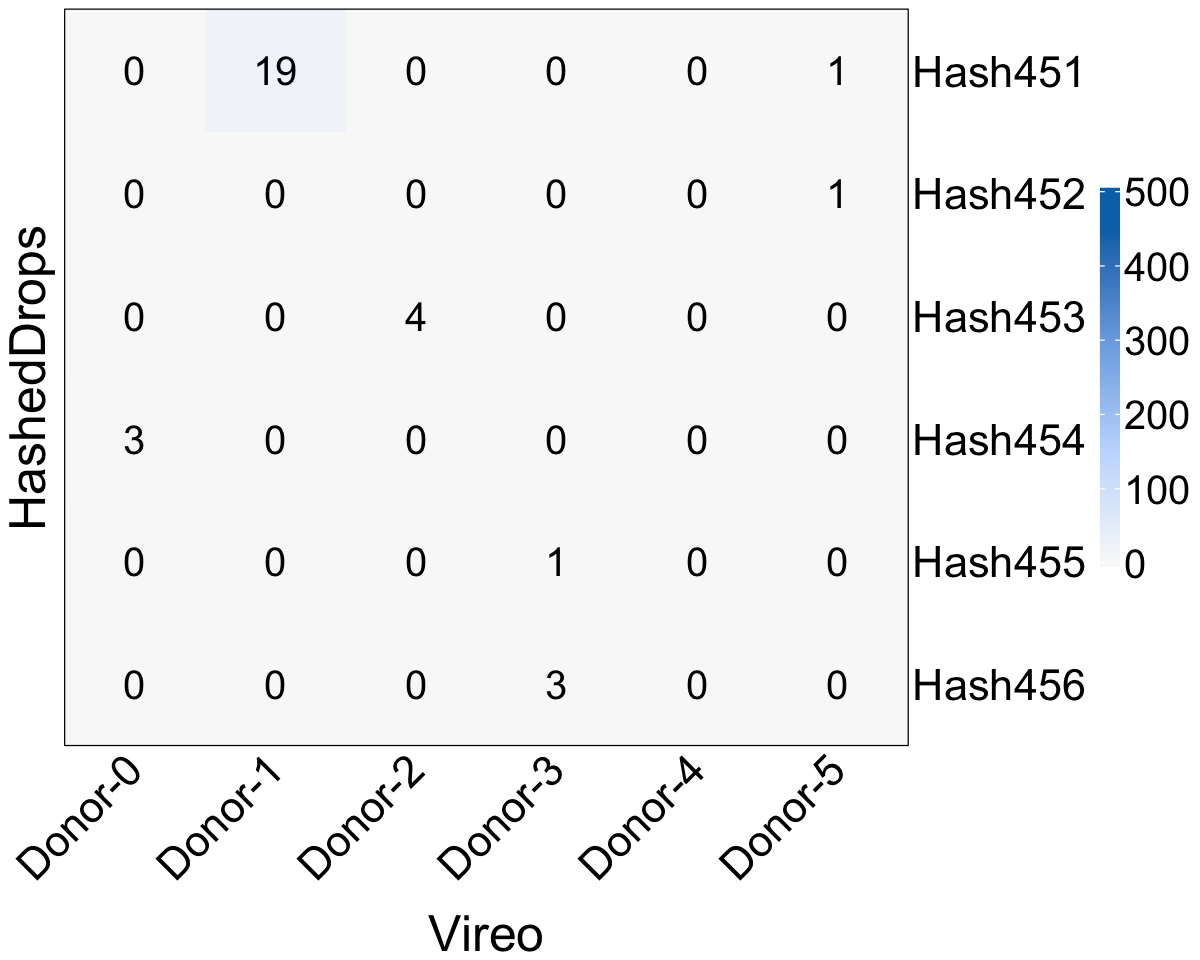

In [9]:
# Create an empyt matrix
confusion_matrix_v_hashedDrops <-
  as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_hashedDrops) <- donor_list_vireo
rownames(confusion_matrix_v_hashedDrops) <- donor_list

for (j in c(0:5)) {
  for (i in c(1:6)) {
    row <-
      nrow(hash_gene_result[hash_gene_result$Vireo == donor_list_vireo[j + 1] &
        hash_gene_result$HashedDrops == donor_list[i], ])
    confusion_matrix_v_hashedDrops[i, j + 1] <- row
  }
}

colnames(confusion_matrix_v_hashedDrops) <- paste0("Donor-", 0:5)

# pdf(
#   "s4/heatmap-v-hashedDrops-gx12.pdf",
#   family = "Myriad Pro",
#   height = 8,
#   width = 10
# )

Heatmap(
  confusion_matrix_v_hashedDrops,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "HashedDrops",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_hashedDrops[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)
# dev.off()


,donor0,donor1,donor2,donor3,donor4,donor5
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,3,1,1,0,0,0
Hash452,0,0,0,0,1,0
Hash453,0,0,0,0,0,0
Hash454,31,34,21,23,7,24
Hash455,7,10,8,3,3,5
Hash456,1,2,0,1,0,1


Warning message:
"The input is a data frame-like object, convert it to a matrix."


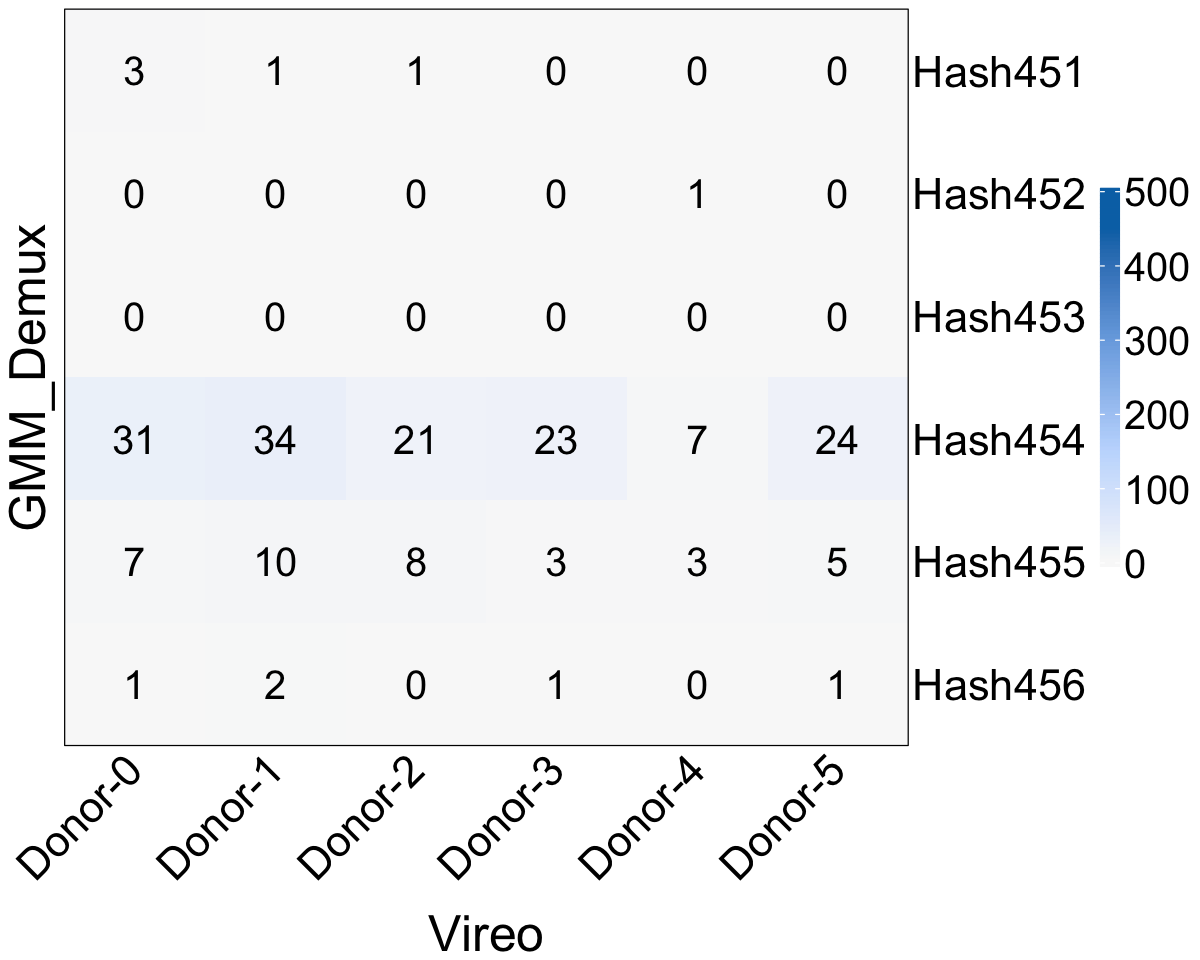

In [10]:
# Create an empyt matrix
confusion_matrix_v_gmmdemux <-
  as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_gmmdemux) <- donor_list_vireo
rownames(confusion_matrix_v_gmmdemux) <- donor_list

for (j in c(0:5)) {
  for (i in c(1:6)) {
    row <-
      nrow(hash_gene_result[hash_gene_result$Vireo == donor_list_vireo[j + 1] &
        hash_gene_result$GMM_Demux == donor_list[i], ])
    confusion_matrix_v_gmmdemux[i, j + 1] <- row
  }
}
confusion_matrix_v_gmmdemux
colnames(confusion_matrix_v_gmmdemux) <- paste0("Donor-", 0:5)

# pdf(
#   "s4/heatmap-v-gmmdemux-gx12.pdf",
#   family = "Myriad Pro",
#   height = 8,
#   width = 10
# )

Heatmap(
  confusion_matrix_v_gmmdemux,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "GMM_Demux",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_gmmdemux[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)
# dev.off()


Warning message:
"The input is a data frame-like object, convert it to a matrix."


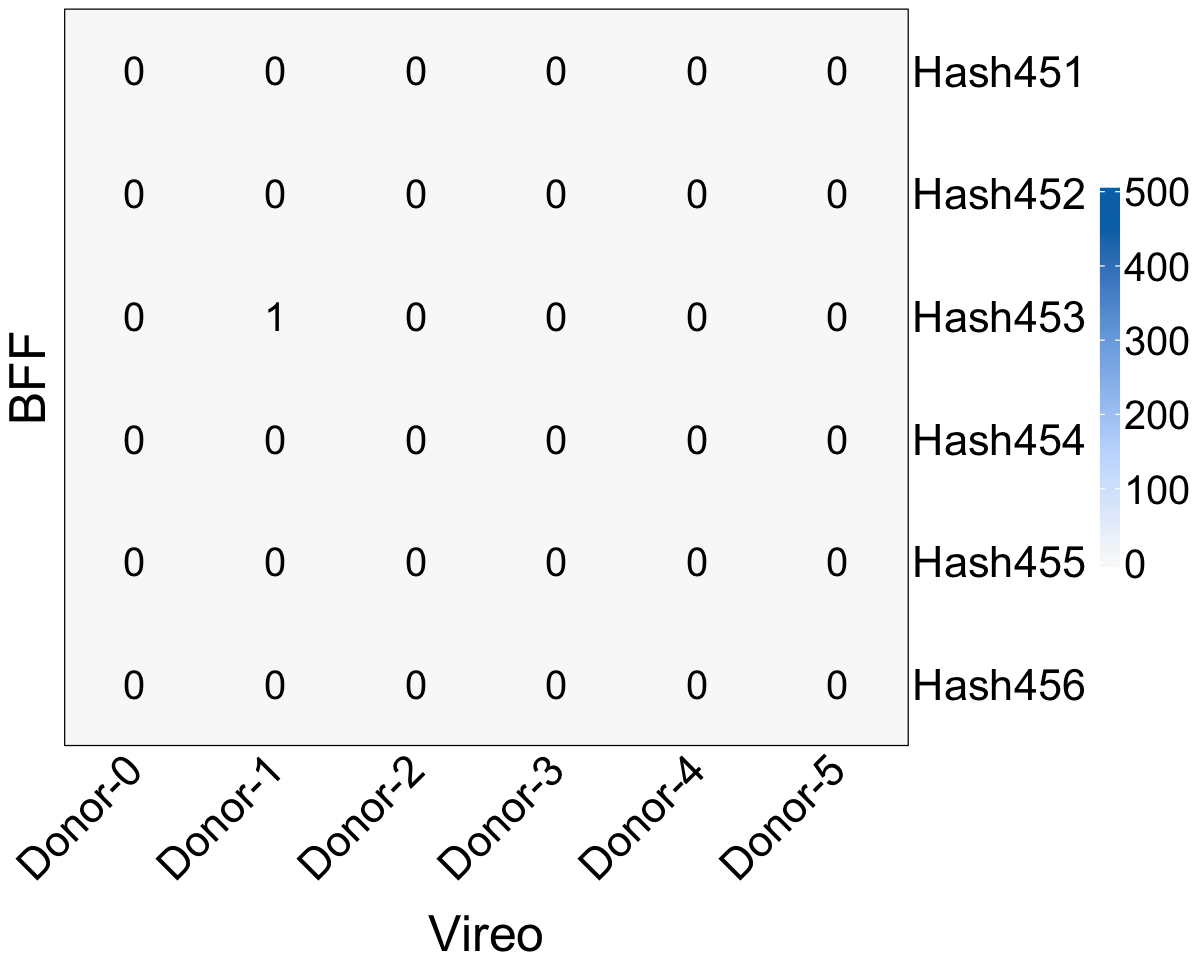

In [11]:
# Create an empyt matrix
confusion_matrix_v_bff <- as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_bff) <- donor_list_vireo
rownames(confusion_matrix_v_bff) <- donor_list

for (j in c(0:5)) {
  for (i in c(1:6)) {
    row <-
      nrow(hash_gene_result[hash_gene_result$Vireo == donor_list_vireo[j + 1] &
        hash_gene_result$BFF == donor_list[i], ])
    confusion_matrix_v_bff[i, j + 1] <- row
  }
}
colnames(confusion_matrix_v_bff) <- paste0("Donor-", 0:5)

# pdf(
#   "s4/heatmap-v-bff-gx12.pdf",
#   family = "Myriad Pro",
#   height = 8,
#   width = 10
# )

Heatmap(
  confusion_matrix_v_bff,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "BFF",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_bff[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)
# dev.off()
